<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/Solar_Panel_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solar Energy Prediction 

In this notebook, we look at two forms of solar panel production data:
* High resolution data gathered every five to fifteen minutes.  
* Low resolution daily total energy production.  

For both of these types of data, we will perform multiple regression algorithms to try and forecast future energy production.

In [202]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

#High Resolution

This data file contains date/time information and the total power produced in kilowatts in 5 minute increments. 

Because the data in this file has been modified to remove the night-time information, this program is designed to work exclusively with the Cyprus datasets created by Josh.  Code modification will be required for this to work with other data.

## Load Data

In [2]:
from google.colab import files
uploaded = files.upload() #Load 80929.csv 

Saving 80929.csv to 80929.csv


We're going to read our csv file into a Pandas DataFrame.  To distinguish this dataframe from later dataframes, we will call it df_hr for "dataframe high resolution".

In [3]:
data_path = '/content/80929.csv'
df_hr = pd.read_csv(data_path, delimiter=',') 
df_hr

,Date,Power (kW)
0,9/30/2014 8:50,0.0
1,9/30/2014 8:55,1032.0
2,9/30/2014 9:00,1082.5
3,9/30/2014 9:05,1094.5
4,9/30/2014 9:10,1175.5
...,...,...
302423,6/4/2020 19:48,1.5
302424,6/4/2020 19:53,0.0
302425,6/4/2020 19:56,0.0
302426,6/4/2020 20:01,0.0


## Clean Data

At this point, I'm going to remove the date/time information and only retain the energy signal.  This date/time information may be useful in other applications in the future, but for now we don't need it.

In [4]:
df_y_hr = df_hr.drop(columns=['Date'])
df_y_hr

,Power (kW)
0,0.0
1,1032.0
2,1082.5
3,1094.5
4,1175.5
...,...
302423,1.5
302424,0.0
302425,0.0
302426,0.0


At this point, we're going to pull the data out of the Pandas dataframe and into a Numpy array.  The algorithms we're going to use require Numpy arrays.  Fortunately, it is quite easy to convert between the two.

As we only have one datastream, we actually only have the labels, or y values, to work with.  To deal with this, we will also create an input vector X that corresponds to the row number in the dataframe above.  We will use a linespace to do this. As the linespace produces floating point numbers rather than integers, we then convert the values to integers.

In [5]:
y_hr = df_y_hr.to_numpy()

#Create an input vector of just the values between 0 and 302,427
X_hr = np.linspace(0, y_hr.shape[0], y_hr.shape[0]).astype(int)

## Forecasting

Now that we have the data loaded, we can run a regression algorithm on it to try and forecast future values.  We're going to start with a linear regression from sklearn.

In [6]:
model_hr = LinearRegression(fit_intercept=True) #The fit_intercept=True means that 
                                             #we are not assuming the data is 
                                             #pre-centered
model_hr.fit(X_hr[:, np.newaxis], y_hr) #The np.newaxis is required here because when x 
                               #was created, it was 1d: shape = (50,). Model.fit 
                               #requires 2d data. New shape = (50,1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Use the following form to specify how many days worth of data to view and the starting day out of the number.  

In [93]:
days_to_view_hr =  10#@param {type:"integer"}

starting_day_hr = 998 #@param {type:"slider", min:1, max:2000, step:1}

Text(0.5, 1.0, 'High resolution energy usage for 10 days.')

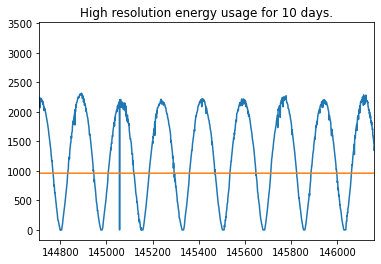

In [94]:
y_hat_hr = model_hr.predict(X_hr[:, np.newaxis])

plt.plot(X_hr, y_hr)
plt.plot(X_hr, y_hat_hr);

approx_samples_per_day = 145

plt.xlim(starting_day_hr*approx_samples_per_day, 
         starting_day_hr*approx_samples_per_day + days_to_view_hr*approx_samples_per_day)

plt.title("High resolution energy usage for " + str(days_to_view_hr) + " days.")

Let's see what the equation of this prediction line is.

In [106]:
coefficients_hr = model_hr.coef_
slope_hr = coefficients_hr[0][0]
intercept_hr = model_hr.intercept_[0]

print("f(x) = ", round(slope_hr, 6), "* x + ", round(intercept_hr, 2))
years_of_data_hr = y_hr.shape[0] / 365 / approx_samples_per_day

degredation_hr = str(round(slope_hr * 100, 4))
print("Solar panel degredation for all time = ", degredation_hr, "%")
degredation_per_year_hr = str(round(slope_hr * 100 / years_of_data_hr, 4))
print("Solar panel degredation per year over time = ", degredation_per_year_hr, "%")

f(x) =  -5.7e-05 * x +  969.13
Solar panel degredation for all time =  -0.0057 %
Solar panel degredation per year over time =  -0.001 %
5.714274917335852


Notice that this fitted line is decreasing very slowly.  In fact it works out to approximately 0.001% decrease per year.  This is probably due to two factors:
* Solar panels degrade over time, typically less than 1% per year, though this seems especially low.
* Having start and end dates at different times of the year will also effect this value.  For example, if the start date is the middle of summer and the end date is the middle of winter, there will be an inherant downwards bias.



## Solar Panel Degredation

To identify the actual solar panel degration, we need to choose a time period that starts and stops on the same day of the year.  We know we have more than five years of data total, so we're going to extract excactly 5 years from it.  Because each day's worth of data can have a different number of data samples, this was done by hand using trial and error. The five years of data begins on January 1st, 2015 and ends on December 31th, 2019.

We need to fit a new line to this adjusted datset.

In [60]:
df_hr.loc[11759: 279574]

,Date,Power (kW)
11759,1/1/2015 6:55,0.0
11760,1/1/2015 7:00,0.0
11761,1/1/2015 7:05,0.0
11762,1/1/2015 7:10,0.0
11763,1/1/2015 7:15,21.0
...,...,...
279570,12/31/2019 16:39,0.0
279571,12/31/2019 16:44,0.0
279572,12/31/2019 16:46,0.0
279573,12/31/2019 16:51,0.0


In [109]:
y_five_years_hr = df_hr.drop(columns=['Date']).loc[11759: 279574].to_numpy()
X_five_years_hr = np.linspace(0, y_five_years_hr.shape[0], y_five_years_hr.shape[0]).astype(int)

model_five_years_hr = LinearRegression(fit_intercept=True)
model_five_years_hr.fit(X_five_years_hr[:, np.newaxis], y_five_years_hr)

five_year_coefficients_hr = model_five_years_hr.coef_
five_year_slope_hr = five_year_coefficients_hr[0][0]
five_year_intercept_hr = model_five_years_hr.intercept_[0]

print("The line that best fits this five years of data is:")
print("f(x) = ", round(five_year_slope_hr, 4), "* x + ", round(five_year_intercept_hr, 2))

The line that best fits this five years of data is:
f(x) =  -0.0003 * x +  1015.42


Notice that this is a steeper slope than we found before we accounted for the start and end days.  Using this, we can correctly calculate the percentage degradation over time. This degredation is still very small at less than 0.01% per year.

In [101]:
degredation_five_years_hr = str(round(five_year_slope_hr * 100, 4))
print("Solar panel degredation for all time = ", degredation_five_years_hr, "%")

degredation_per_year_hr = str(round(five_year_slope_hr * 100 / 5, 4))
print("Solar panel degredation per year over time = ", degredation_per_year_hr, "%")

Solar panel degredation for all time =  -0.0306 %
Solar panel degredation per year over time =  -0.0061 %


Even though this model does not fit the minute by minute data effectively, it is still able to give us a general idea of how the solar panels are performing over time.  In this case, we see an expected slight degredation over time, though it is perhaps less than expected due to the manufacturer claims of less than 1% per year.  The actual degredation of 0.006% a year is substantially lower than this guarentee.

To actually fit this prediction minute by minute, a deep learning algorithm called a Recurrent Neural Network (RNN) or an Long Short-Term Memory Recurrent Neural Network (LSTM) would be required.  Instead, let's look at a problem that linear regression CAN solve.


#Low Resolution

Instead of looking at the daily cycles of energy production, here we're going to look just at how much total energy was produced each day.  This will still be cyclical with the seasons, but it will be "locally stationary", meaning that over short periods of time (1 to 2 months), the curve will look roughly linear.

## Load Data

Because the previous dataset ignored the zero production during the night, each day is not going to have the same number of data points.  Summer days will contain more five minute data samples than will the shorter days of winter.

To simplify matters, the daily totals have been calculated externally and we will load them in now.  Any dataset with daily total energy production can be used here effectively.

In [114]:
from google.colab import files
uploaded = files.upload() #Load 80929_energy_per_day.csv or other daily total energy summaries

Saving 80929_energy_per_day.csv to 80929_energy_per_day (1).csv


In [115]:
data_path_totals = '/content/80929_energy_per_day.csv'
df_daily = pd.read_csv(data_path_totals, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame
df_daily

,Date,9029_Energy_Per_Day
0,9/30/2014,12.533417
1,10/1/2014,14.201500
2,10/2/2014,13.026417
3,10/3/2014,13.852000
4,10/4/2014,13.651958
...,...,...
2070,5/31/2020,19.063875
2071,6/1/2020,18.135750
2072,6/2/2020,16.941333
2073,6/3/2020,18.265833


## Clean Data

At this point, I'm going to remove the date/time information and only retain the energy signal.  This date/time information may be useful in other applications in the future, but for now we don't need it.

In [116]:
df_y_daily = df_daily.drop(columns=['Date'])
df_y_daily

,9029_Energy_Per_Day
0,12.533417
1,14.201500
2,13.026417
3,13.852000
4,13.651958
...,...
2070,19.063875
2071,18.135750
2072,16.941333
2073,18.265833


As we did above, we're going to pull the data out of the Pandas dataframe and into a Numpy array.  The algorithms we're going to use require Numpy arrays.  Fortunately, it is quite easy to convert between the two.

As we only have one datastream, we actually only have the labels, or y values, to work with.  To deal with this, we will also create an input vector X that corresponds to the row number in the dataframe above.  We will use a linespace to do this. As the linespace produces floating point numbers rather than integers, we then convert the values to integers.

In [117]:
y_daily = df_y_daily.to_numpy()
X_daily = np.linspace(0, y_daily.shape[0], y_daily.shape[0])

Let's now take a look at this data.  
* If you make the days_to_view_daily large, you'll see that the data is very cyclic due to the seasons.  
* If you keep it smaller, from a couple of weeks to a couple of months, you'll see that it looks more like a jagged line - the downward spikes correspond to cloudy days.

In [136]:
days_to_view_daily =  60#@param {type:"integer"}

starting_day_daily = 910 #@param {type:"slider", min:1, max:2000, step:1}

Text(0.5, 1.0, "('Energy daily totals for ', 60, ' days.')")

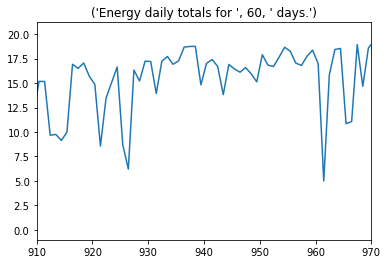

In [137]:
plt.plot(X_daily, y_daily)
plt.xlim(starting_day_daily, starting_day_daily + days_to_view_daily)

title = 'Energy daily totals for ', days_to_view_daily, ' days.'
plt.title(title)

## Linear Regression Forecasting

Now that this short-term data looks more linear, let's use a linear regression over a local area that won't change too much over time.

In [159]:
days_to_view_daily =  60#@param {type:"integer"}

starting_day_daily = 1 #@param {type:"slider", min:1, max:2000, step:1}

days_to_predict = 5 #@param {type:"integer"}

### Create Train/Validation/Test Sets

Because we're performing regression, there are two ways to divide our data:
1. We could randomly select 70% of the data points to be in the training set, 15% to be in the validation set, and the remaining 15% to be in the test set.  These sets will therefore be completely overlapping, and only scattered points would be predicted and compared.
2. We could train on the first 70% of the dataset, validate on the next 15%, and test on the final 15%.

Both these techniques are used in regression problems, but because our data is sequential and has an order, we're going to use method 2.  However, in this case we are specifying the number of days to train on (days_to_view_daily) and the number of days to test on (days_to_predict) so we will only split up the training days into a train/validation set.

In [160]:
#Training set
X_local_train = X_daily[:, np.newaxis][starting_day_daily:starting_day_daily + 
                                       int(0.7 * days_to_view_daily)]
y_local_train = y_daily[starting_day_daily:starting_day_daily + 
                        int(0.7 * days_to_view_daily)]

#Validation set
X_local_validate = X_daily[:, np.newaxis][starting_day_daily + 
                                       int(0.7 * days_to_view_daily):
                                       starting_day_daily + 
                                       days_to_view_daily]
y_local_validate = y_daily[starting_day_daily + 
                           int(0.7 * days_to_view_daily):
                           starting_day_daily + days_to_view_daily]                                      

#Test set
X_local_test = X_daily[:, np.newaxis][starting_day_daily + days_to_view_daily: 
                                      starting_day_daily + days_to_view_daily + 
                                      days_to_predict]
y_local_test = y_daily[starting_day_daily + days_to_view_daily: 
                       starting_day_daily + days_to_view_daily + 
                       days_to_predict]

In [161]:
print("X_local_train.shape", X_local_train.shape)
print("y_local_train.shape", y_local_train.shape)
print("\nX_local_validate.shape", X_local_validate.shape)
print("y_local_validate.shape", y_local_validate.shape)
print("\nX_local_test.shape", X_local_test.shape)
print("y_local_test.shape", y_local_test.shape)

X_local_train.shape (42, 1)
y_local_train.shape (42, 1)

X_local_validate.shape (18, 1)
y_local_validate.shape (18, 1)

X_local_test.shape (5, 1)
y_local_test.shape (5, 1)


### Tune Hyperparameters

We're going to use polynomial features to find the best fit to our local, relatively stationary data.  The polynomial features will help with the slight seasonal changes that will still be present even on small amounts of data. 

In [164]:
for i in range(10):
    model_daily = make_pipeline(PolynomialFeatures(i), LinearRegression())    
    model_daily.fit(X_local_train, y_local_train)  
    y_hat_daily_val = model_daily.predict(X_local_validate)

    MSE_val_ave = mean_squared_error(y_local_validate, y_hat_daily_val) / X_local_validate.shape[0]
    print(i, ' poly features -> daily MSE for Validation = ', MSE_val_ave)

0  poly features -> daily MSE for Validation =  0.9838115441217692
1  poly features -> daily MSE for Validation =  0.14362125790310862
2  poly features -> daily MSE for Validation =  0.6289241067836195
3  poly features -> daily MSE for Validation =  2.792402058396281
4  poly features -> daily MSE for Validation =  1.2870867394546572
5  poly features -> daily MSE for Validation =  0.9014235931950204
6  poly features -> daily MSE for Validation =  1130.5488489357876
7  poly features -> daily MSE for Validation =  34842.60858992869
8  poly features -> daily MSE for Validation =  16804.026548061058
9  poly features -> daily MSE for Validation =  1585636.226522808


### Perform Final Tests
The mean squared error (MSE) for the validation set is going to depend on the forecasting parameters you set above.  Select whatever number of polynomial features works best for the data you selected and train a final model using both the training and validation sets.

In [201]:
#Combine our original training and validation sets into one final set for our 
#final model.
X_local_final_train = np.concatenate((X_local_train, X_local_validate), axis=0)
y_local_final_train = np.concatenate((y_local_train, y_local_validate), axis=0)

#Retrain the model
model_local_final = make_pipeline(PolynomialFeatures(2), LinearRegression())    
model_local_final.fit(X_local_final_train, y_local_final_train)  
y_hat_daily_final = model_local_final.predict(X_local_test)

MSE_test_ave = mean_squared_error(y_local_test, y_hat_daily_final) / days_to_predict
print('Daily MSE for Test Set = ', MSE_test_ave)

prediction = y_hat_daily_final 
real = y_local_test 

predictions = pd.DataFrame(np.concatenate((real, prediction), axis=1), 
                           columns={"Real", "Predictions"})
predictions

Daily MSE for Test Set =  0.02797704370684919


,Real,Predictions
0,6.236292,5.469586
1,5.582833,5.458672
2,5.595917,5.452048
3,5.190833,5.449715
4,5.543625,5.451671


### Visualization

Once we have our final model and predictions, we can visualize our model.  Here, we're going to predict values for the entire set of data to assist in visualization.

In [191]:
days_to_view = 'All Data' #@param ["All Data", "Only Validation and Test", "Only Test"]

Text(0.5, 1.0, 'All Data')

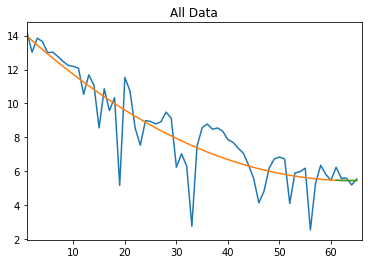

In [219]:
X_local_all = np.concatenate((X_local_final_train, X_local_test), axis=0)
y_local_all = np.concatenate((y_local_final_train, y_local_test), axis=0)

y_hat_all = model_local_final.predict(X_local_all)

plt.plot(X_local_all, y_local_all)
plt.plot(X_local_all, y_hat_all)
plt.plot(X_local_test, y_hat_daily_final)

if days_to_view == "All Data":
    plt.xlim(starting_day_daily, 
             starting_day_daily + days_to_view_daily + days_to_predict)
elif days_to_view == "Only Validation and Test":
    plt.xlim(starting_day_daily + int(0.7*days_to_view_daily), 
             starting_day_daily + days_to_view_daily + days_to_predict)
elif days_to_view == "Only Test":
    plt.xlim(starting_day_daily + days_to_view_daily, 
             starting_day_daily + days_to_view_daily + days_to_predict)

plt.title(days_to_view)

## Neural Network (Multi-layer Preceptrons) Forecasting

Multi-layer Preceptrons are shallow neural networks (as opposed to deep learning networks).  This means that they usually only have a couple of hidden layers.  

These networks generally have the following structure:


![picture](https://www.tutorialspoint.com/tensorflow/images/multi_layer_perceptron.jpg)

We will use the same data that from the linear regression section above.

### Tune Hyperparameters

We're definitely going to have to do some hyperparameter tuning on this - neural nets have more hyperparameters than other methods.

Here, our hyperparameters consist of:
* The number of hidden layers
* The number of hidden nodes in each hidden layer
* The activation function which can be identity’, ‘logistic’, ‘tanh’, or ‘relu’ ('relu' is fairly standard).  See the documentation for more details.
* The type of solver which can be ‘lbfgs’, ‘sgd’, or ‘adam’.  'sgd' is standard gradiant descent, while 'adam' is a specialized version of gradient descent ('adam' is fairly standard)
* The max_iter specifies the maximum number of iterations.

The following code automatically tests a variety of hidden layers and hidden nodes though it uses the standard 'relu' activation function and 'adam' solver.  Feel free to play with these as well.

In [212]:
#Try different hyperparameter values
hidden_layers = [25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

#Let's try for just one hidden layer
for hl in hidden_layers:
  NN_model_train = MLPRegressor(hidden_layer_sizes=(hl, ), activation='relu', solver='adam', max_iter=5000)
  NN_model_train.fit(X_local_train, y_local_train.ravel())
  nn_y_hat_val = NN_model_train.predict(X_local_validate)

  nn_MSE_val = mean_squared_error(y_local_validate, nn_y_hat_val) / X_local_validate.shape[0]
  print('One hidden layer, ', hl, ' nodes. Ave validation MSE = ', nn_MSE_val)

#Now we'll try two hidden layers
for hl in hidden_layers:
  NN_model_train = MLPRegressor(hidden_layer_sizes=(hl, hl), activation='relu', solver='adam', max_iter=5000)
  NN_model_train.fit(X_local_train, y_local_train.ravel())
  nn_y_hat_val = NN_model_train.predict(X_local_validate)

  nn_MSE_val = mean_squared_error(y_local_validate, nn_y_hat_val) / X_local_validate.shape[0]
  print('Two hidden layers, ', hl, ' nodes. Ave validation MSE = ', nn_MSE_val)

One hidden layer,  25  nodes. Ave validation MSE =  0.16674124465745774
One hidden layer,  50  nodes. Ave validation MSE =  0.15385821619104
One hidden layer,  100  nodes. Ave validation MSE =  7.011108228049989
One hidden layer,  150  nodes. Ave validation MSE =  7.799795720995184
One hidden layer,  200  nodes. Ave validation MSE =  0.16691689758011707
One hidden layer,  250  nodes. Ave validation MSE =  8.551328296336756
One hidden layer,  300  nodes. Ave validation MSE =  9.474569136819841
One hidden layer,  350  nodes. Ave validation MSE =  8.825490687900375
One hidden layer,  400  nodes. Ave validation MSE =  9.799377288496652
One hidden layer,  450  nodes. Ave validation MSE =  7.91827460278281
One hidden layer,  500  nodes. Ave validation MSE =  9.434240379517174
Two hidden layers,  25  nodes. Ave validation MSE =  0.08672733619555961
Two hidden layers,  50  nodes. Ave validation MSE =  9.604873010885326
Two hidden layers,  100  nodes. Ave validation MSE =  0.3275980873941379
Tw

### Perform Final Tests
Depending on what data you selected and the randomized order it was put into for training, you will get different ave validation MSE's than I will.

However, I got the lowest MSE with two layers of 400 nodes each.

In [218]:
X_local_final_train

NN_model_final = MLPRegressor(hidden_layer_sizes=(400, 400), activation='relu', solver='adam', max_iter=5000)
NN_model_train.fit(X_local_final_train, y_local_final_train.ravel())
nn_y_hat_test = NN_model_train.predict(X_local_test)

nn_MSE_test = mean_squared_error(y_local_test.ravel(), nn_y_hat_test) / X_local_test.shape[0]
print('Final test MSE ', nn_MSE_test)

prediction = nn_y_hat_test[:, np.newaxis]
real = y_local_test

predictions = pd.DataFrame(np.concatenate((real, prediction), axis=1), 
                           columns={"Real", "Predictions"})
predictions

Final test MSE  0.3373838043038919


,Real,Predictions
0,6.236292,4.547483
1,5.582833,4.451219
2,5.595917,4.355310
3,5.190833,4.259896
4,5.543625,4.166592


### Visualization

Once we have our final model and predictions, we can visualize our model.  Here, we're going to predict values for the entire set of data to assist in visualization.

In [226]:
days_to_view = 'All Data' #@param ["All Data", "Only Validation and Test", "Only Test"]

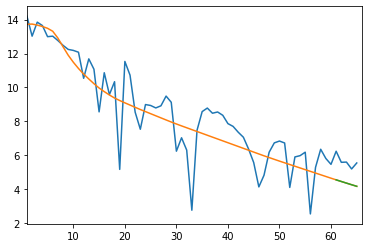

In [227]:
nn_y_hat_all = NN_model_train.predict(X_local_all)

plt.plot(X_local_all, y_local_all)
plt.plot(X_local_all, nn_y_hat_all)
plt.plot(X_local_test, nn_y_hat_test)

if days_to_view == "All Data":
    plt.xlim(starting_day_daily, 
             starting_day_daily + days_to_view_daily + days_to_predict)
elif days_to_view == "Only Validation and Test":
    plt.xlim(starting_day_daily + int(0.7*days_to_view_daily), 
             starting_day_daily + days_to_view_daily + days_to_predict)
elif days_to_view == "Only Test":
    plt.xlim(starting_day_daily + days_to_view_daily, 
             starting_day_daily + days_to_view_daily + days_to_predict)